In [1]:
# Lets import our libraries and use the Python interactive shell to display all results if needed throughout the program

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.model_selection import train_test_split
import os
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Lets load and explore the dataset using pandas

steam_raw = pd.read_csv("./steam-200k.csv",usecols=[0,1,2,3],names=['userid','game','behavior','hoursplayed'])
steam_raw.head()
steam_raw.isnull().values.any()
steam_raw['userid'] = steam_raw.userid.astype(str)
steam_raw.describe()

,userid,game,behavior,hoursplayed
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


False

,hoursplayed
count,200000.000000
mean,17.874384
std,138.056952
min,0.100000
25%,1.000000
50%,1.000000
75%,1.300000
max,11754.000000


In [3]:
# Lets create a new dataframe with the userid and the hours played
# Eastside Hockey Manager has the highest average hours played while Dota 2 has the most hours played

steam_raw.groupby(['game']).mean().sort_values(by="hoursplayed",ascending=False).head()
steam_raw.groupby(['game']).sum().sort_values(by="hoursplayed",ascending=False).head()

,hoursplayed
game,
Eastside Hockey Manager,648.000000
FIFA Manager 09,206.000000
Perpetuum,200.987500
Football Manager 2012,194.501887
Football Manager 2014,194.017722


,hoursplayed
game,
Dota 2,986525.6
Counter-Strike Global Offensive,324183.6
Team Fortress 2,175996.3
Counter-Strike,135117.1
Sid Meier's Civilization V,100417.3


In [4]:
# Let's see how many unique players and how many unique games there are

len(steam_raw['game'].unique())
len(steam_raw['userid'].unique())

5155

12393

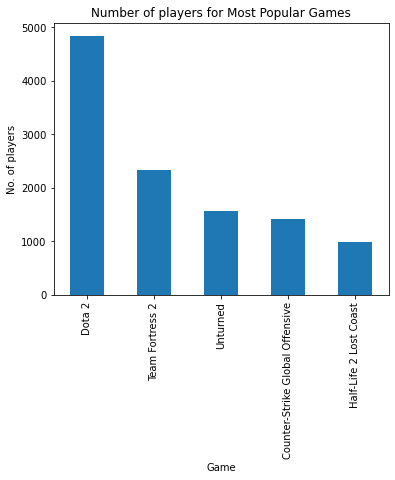

In [5]:
# We can plot the number of players for the most popular games

gb = steam_raw.groupby('game')['userid'].nunique().sort_values(ascending=False).head()
ax = gb.plot(kind='bar', title='Number of players for Most Popular Games', ylabel='No. of players',
         xlabel='Game', figsize=(6, 5))

# ax.bar_label(ax.containers[0])

0    189067
1     10933
Name: like, dtype: int64

,userid,game,behavior,hoursplayed,like
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,1
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,1
4,151603712,Spore,purchase,1.0,0


game
Dota 2                             1417
Counter-Strike Global Offensive     776
Team Fortress 2                     480
The Elder Scrolls V Skyrim          362
Sid Meier's Civilization V          265
Name: like, dtype: int64

game
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Name: userid, dtype: int64

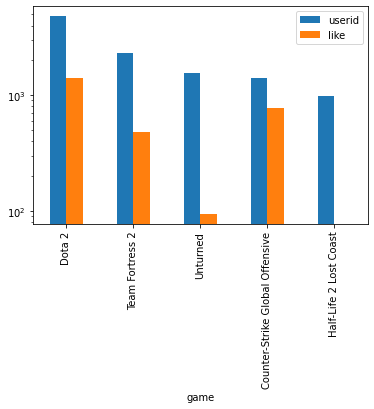

In [6]:
steam_df = steam_raw.copy()
steam_df['like'] = [1 if x > 40 else 0 for x in steam_df['hoursplayed']]
steam_df['like'].value_counts()
steam_df.head()

bg=steam_df.groupby('game')['like'].apply(lambda x: (x==1).sum()).sort_values(ascending=False)
bg.head()
gb.head()
#Plot grouped bar-chart of common games
gbbg = pd.merge(gb, bg, on='game')
gbc = gbbg.plot.bar(logy=True)

In [7]:
x = steam_df.groupby(['userid', 'game'])['behavior'].size()
s = x[x == 1]
len(s)
len(x)

boolean_index = steam_df.groupby(['userid','game'])['behavior'].transform('size') < 2
steam_df.loc[boolean_index,'hoursplayed'] = 0
steam_df.loc[steam_df['hoursplayed']==0]

steam_df.loc[steam_df.hoursplayed==0,'behavior'] = 'play'

steam_df.loc[steam_df['hoursplayed'] ==0]
steam_df = steam_df[steam_df.behavior != 'purchase']

57904

128804

,userid,game,behavior,hoursplayed,like
52,151603712,Alan Wake,purchase,0.0,0
53,151603712,BioShock 2,purchase,0.0,0
54,151603712,Fallen Earth,purchase,0.0,0
55,151603712,Fallout New Vegas Courier's Stash,purchase,0.0,0
56,151603712,Fallout New Vegas Dead Money,purchase,0.0,0
...,...,...,...,...,...
199947,99096740,The Elder Scrolls V Skyrim - Hearthfire,purchase,0.0,0
199956,176449171,Counter-Strike,purchase,0.0,0
199957,176449171,Counter-Strike Condition Zero,purchase,0.0,0
199958,176449171,Counter-Strike Condition Zero Deleted Scenes,purchase,0.0,0


,userid,game,behavior,hoursplayed,like
52,151603712,Alan Wake,play,0.0,0
53,151603712,BioShock 2,play,0.0,0
54,151603712,Fallen Earth,play,0.0,0
55,151603712,Fallout New Vegas Courier's Stash,play,0.0,0
56,151603712,Fallout New Vegas Dead Money,play,0.0,0
...,...,...,...,...,...
199947,99096740,The Elder Scrolls V Skyrim - Hearthfire,play,0.0,0
199956,176449171,Counter-Strike,play,0.0,0
199957,176449171,Counter-Strike Condition Zero,play,0.0,0
199958,176449171,Counter-Strike Condition Zero Deleted Scenes,play,0.0,0


In [8]:
# Create a new dataframe to store metrics
d = {'like':'Sum Likes','hoursplayed':'Avg Hours Played'}
metrics_df = steam_df.groupby(['game'], as_index=False).agg({'like':'sum','hoursplayed':'mean'}).rename(columns=d)
metrics_df.loc[metrics_df['game'] == "Dota 2"] #Check Dota 2

# Calculate mean of Hours Played average
c = metrics_df['Avg Hours Played'].mean()
print("Average hours played across all games is " + str(round(c,2)))

# Calculate the minimum number of likes required, set to 95 percentile
m = metrics_df['Sum Likes'].quantile(0.95)
print("Minimum number of likes for a game is " + str(m))

,game,Sum Likes,Avg Hours Played
1336,Dota 2,1417,202.785499


Average hours played across all games is 6.78
Minimum number of likes for a game is 5.0


In [9]:
metrics_df.shape
metrics_df = metrics_df.loc[metrics_df['Sum Likes'] >= m]
metrics_df.shape
metrics_df.head()

(5155, 3)

(266, 3)

,game,Sum Likes,Avg Hours Played
38,7 Days to Die,22,39.567961
81,APB Reloaded,17,35.256489
84,ARK Survival Evolved,61,83.393252
109,AdVenture Capitalist,33,27.331982
174,Age of Empires II HD Edition,33,28.817227


In [10]:
def weighted_rating(df, m=m, C=c):
    l = df['Sum Likes']
    a = df['Avg Hours Played']
    return (l/(l+m) * a) + (m/(l+m) * C)

metrics_df['score'] = metrics_df.apply(weighted_rating, axis=1)
metrics_df.head()

,game,Sum Likes,Avg Hours Played,score
38,7 Days to Die,22,39.567961,33.495568
81,APB Reloaded,17,35.256489,28.783886
84,ARK Survival Evolved,61,83.393252,77.588993
109,AdVenture Capitalist,33,27.331982,24.627384
174,Age of Empires II HD Edition,33,28.817227,25.917202


In [11]:
metrics_df.sort_values(by=['score'],ascending=False).head(15)

,game,Sum Likes,Avg Hours Played,score
1762,Football Manager 2012,64,385.572500,358.123553
1764,Football Manager 2014,60,382.185000,353.307464
1763,Football Manager 2013,77,310.659615,292.130190
1760,Football Manager 2010,23,345.439474,284.964039
1765,Football Manager 2015,58,307.381013,283.523554
1761,Football Manager 2011,24,333.435294,277.114905
981,Counter-Strike Global Offensive,776,228.591785,227.171716
1336,Dota 2,1417,202.785499,202.096299
1620,FINAL FANTASY XIV A Realm Reborn,9,264.740000,172.610371
3825,Sid Meier's Civilization V,265,167.485403,164.509322


In [12]:
steam_df
len(steam_df['game'].unique())
len(steam_df['userid'].unique())
len(steam_df)

,userid,game,behavior,hoursplayed,like
1,151603712,The Elder Scrolls V Skyrim,play,273.0,1
3,151603712,Fallout 4,play,87.0,1
5,151603712,Spore,play,14.9,0
7,151603712,Fallout New Vegas,play,12.1,0
9,151603712,Left 4 Dead 2,play,8.9,0
...,...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4,0
199993,128470551,Magic Duels,play,2.2,0
199995,128470551,Titan Souls,play,1.5,0
199997,128470551,Grand Theft Auto Vice City,play,1.5,0


5155

12392

128393

In [13]:
games_df = pd.DataFrame(steam_df.game.unique(), columns=['game'])
games_df['index_col'] = games_df.index
games_df

steam_df = steam_df.merge(games_df, on='game')
steam_df.head()

steam_df['hoursplayed'].std()
steam_df['hoursplayed'].mean()

,game,index_col
0,The Elder Scrolls V Skyrim,0
1,Fallout 4,1
2,Spore,2
3,Fallout New Vegas,3
4,Left 4 Dead 2,4
...,...,...
5150,Warriors & Castles,5150
5151,Romance of the Three Kingdoms Maker,5151
5152,Space Colony,5152
5153,Life is Hard,5153


,userid,game,behavior,hoursplayed,like,index_col
0,151603712,The Elder Scrolls V Skyrim,play,273.0,1,0
1,59945701,The Elder Scrolls V Skyrim,play,58.0,1,0
2,53875128,The Elder Scrolls V Skyrim,play,0.0,0,0
3,92107940,The Elder Scrolls V Skyrim,play,110.0,1,0
4,250006052,The Elder Scrolls V Skyrim,play,465.0,1,0


171.65756611779295

26.834529919856713

In [14]:
usergroup = steam_df.groupby('userid')
usergroup.head()

noOfUsers = 1000

train_list = []

i = 0
# For each user in the group
for userID, cur in usergroup:
    # Create a temp that stores every game's hours played
    temp = [0]*len(games_df)
    # For each game in list
    for no, game in cur.iterrows():
        temp[game['index_col']] = game['hoursplayed']
        i+=1
    train_list.append(temp)
    
    if noOfUsers == 0:
        break
    noOfUsers -= 1


,userid,game,behavior,hoursplayed,like,index_col
0,151603712,The Elder Scrolls V Skyrim,play,273.0,1,0
1,59945701,The Elder Scrolls V Skyrim,play,58.0,1,0
2,53875128,The Elder Scrolls V Skyrim,play,0.0,0,0
3,92107940,The Elder Scrolls V Skyrim,play,110.0,1,0
4,250006052,The Elder Scrolls V Skyrim,play,465.0,1,0
...,...,...,...,...,...,...
128313,162653477,Fast & Furious Showdown,play,3.4,0,5077
128340,213854339,Eastside Hockey Manager,play,1295.0,1,5102
128341,213854339,Franchise Hockey Manager 2,play,11.2,0,5103
128345,178144284,Phantom Breaker Battle Grounds - Kurisu Makise...,play,0.0,0,5107


In [16]:
# Setting the models Parameters

hiddenUnits = 50
visibleUnits = len(steam_raw['game'].unique())
vb = tf.placeholder(tf.float32, [visibleUnits])  
hb = tf.placeholder(tf.float32, [hiddenUnits]) 
W = tf.placeholder(tf.float32, [visibleUnits, hiddenUnits]) 

# Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)  
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0)))) 

# Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

# Learning rate
alpha = 1

# Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)

# Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])

# Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

# Set the error function, here we use Mean Absolute Error Function
err = v0 - v1
err_sum = tf.reduce_mean(err*err)

err_sum

<tf.Tensor 'Mean_5:0' shape=() dtype=float32>

140.6991
140.70053
140.70894
140.71208
140.71045
140.7089
140.70505
140.70235
140.70009
140.69833
140.69656
140.69537
140.69379
140.69281
140.69235
140.69131
140.69106
140.69023
140.68976
140.68922
140.68857
140.68861
140.68857
140.68811
140.68759
140.68744
140.68703
140.68677
140.68665
140.68718


Text(0, 0.5, 'Error')

Text(0.5, 0, 'Epoch')

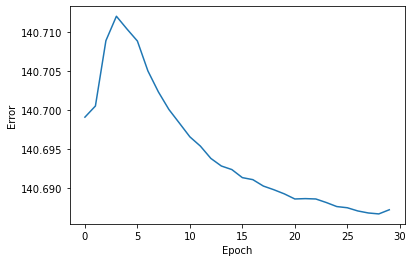

In [17]:
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

cur_vb = np.zeros([visibleUnits], np.float32)

cur_hb = np.zeros([hiddenUnits], np.float32)

prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)

prv_vb = np.zeros([visibleUnits], np.float32)

prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 30
batchsize = 150
errors = []
for i in range(epochs):
    for start, end in zip(range(0, len(train_list), batchsize), range(batchsize, len(train_list), batchsize)):
        batch = train_list[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_hb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: train_list, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print(errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [18]:
inputUser = [train_list[150]]
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={hh0: feed, W: prv_w, vb: prv_vb})

# List the 10 most recommended games for our mock user
inputuser_games = games_df
inputuser_games["Recommendation Score"] = rec[0]
inputuser_games.sort_values(["Recommendation Score"], ascending=False).head(10)

userid = steam_df.iloc[150]['userid']

# Find the games this input user has played
muser_df = steam_df.loc[(steam_df['userid'] == userid) & (steam_df['hoursplayed'] >0)]
muser_df

,game,index_col,Recommendation Score
0,The Elder Scrolls V Skyrim,0,1.0
75,Grand Theft Auto V,75,1.0
183,Borderlands 2,183,1.0
91,Portal 2,91,1.0
407,Kerbal Space Program,407,1.0
1226,Medieval II Total War Kingdoms,1226,1.0
83,Rocket League,83,1.0
1,Fallout 4,1,1.0
81,Far Cry 3,81,1.0
1208,Stronghold Kingdoms,1208,1.0


,userid,game,behavior,hoursplayed,like,index_col
150,101725007,The Elder Scrolls V Skyrim,play,0.6,0,0
3356,101725007,Team Fortress 2,play,41.0,1,9
8139,101725007,Dota 2,play,31.0,0,21
13100,101725007,Garry's Mod,play,2.4,0,24
16319,101725007,FINAL FANTASY XIII,play,0.9,0,41
18339,101725007,Counter-Strike Global Offensive,play,152.0,1,53
20551,101725007,Magicka,play,0.4,0,66
25466,101725007,DayZ,play,1.4,0,105
35737,101725007,Strike Vector,play,0.1,0,230
48514,101725007,PAYDAY 2,play,11.3,0,442


In [19]:
df_all = inputuser_games.merge(muser_df, how='left', indicator=True)
unplayed_games = df_all[df_all['_merge']=='left_only']

# Any Top 5 recommended games for input user which he haven't played
unplayed_games.loc[:,['game','Recommendation Score']].sort_values(['Recommendation Score'], ascending=False).head(5)

,game,Recommendation Score
1,Fallout 4,1.0
620,AdVenture Capitalist,1.0
611,Counter-Strike,1.0
605,APB Reloaded,1.0
604,Tom Clancy's Ghost Recon Phantoms - NA,1.0


KNN - Using the nearest neighbor

In [20]:
import math
from scipy import stats
import statistics as st

import operator

In [23]:
steam_raw = pd.read_csv("./steam-200k.csv", header=None, names=["User_ID", "Game", "Interaction", "Hours", "Ignore"])

steam_raw = steam_raw.drop("Ignore", axis =1)
steam1 = steam_raw
#clean up the table so that it only shows the hours put into each game
#if a user has purchased but not played the game, the hours will be 0
steam1 = steam_raw[steam_raw['Interaction'] == "purchase"]
steam2 = steam_raw[steam_raw['Interaction'] == "play"]
steam3 = pd.merge(steam1, steam2, how = 'left', left_on = ['User_ID', 'Game'], right_on = ['User_ID', 'Game'])
steam3['Hours_y'] = steam3['Hours_y'].fillna(0)



In [24]:
# put it all into a clean table
steam_clean = steam3.drop(['Interaction_x', 'Interaction_y', 'Hours_x'], axis = 1)
steam_clean.head()
steam_clean.info()

,User_ID,Game,Hours_y
0,151603712,The Elder Scrolls V Skyrim,273.0
1,151603712,Fallout 4,87.0
2,151603712,Spore,14.9
3,151603712,Fallout New Vegas,12.1
4,151603712,Left 4 Dead 2,8.9


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129535 entries, 0 to 129534
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User_ID  129535 non-null  int64  
 1   Game     129535 non-null  object 
 2   Hours_y  129535 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.0+ MB


In [25]:
print("Max " + str(steam_clean['Hours_y'].max())
    + "\nMean " + str(steam_clean['Hours_y'].mean()) 
      + "\nMedian " + str(steam_clean['Hours_y'].median()) 
      + "\nMode " + str(steam_clean['Hours_y'].mode()))

Max 11754.0
Mean 26.65100783572067
Median 0.3
Mode 0    0.0
dtype: float64


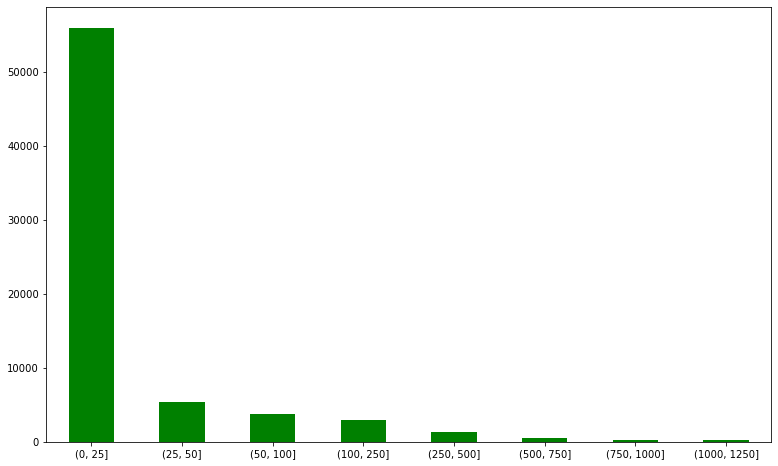

In [26]:
out = pd.cut(steam_clean['Hours_y'], bins = [0, 25, 50, 100, 250, 500, 750, 1000, 1250])
ax = out.value_counts(sort=False).plot.bar(rot=0, color="green", figsize = (13, 8))

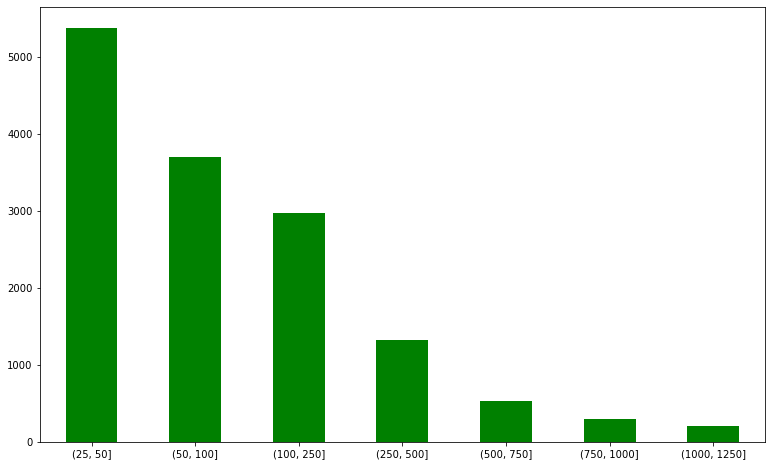

In [27]:
out = pd.cut(steam_clean['Hours_y'], bins = [25, 50, 100, 250, 500, 750, 1000, 1250])
ax = out.value_counts(sort=False).plot.bar(rot=0, color="green", figsize = (13, 8))

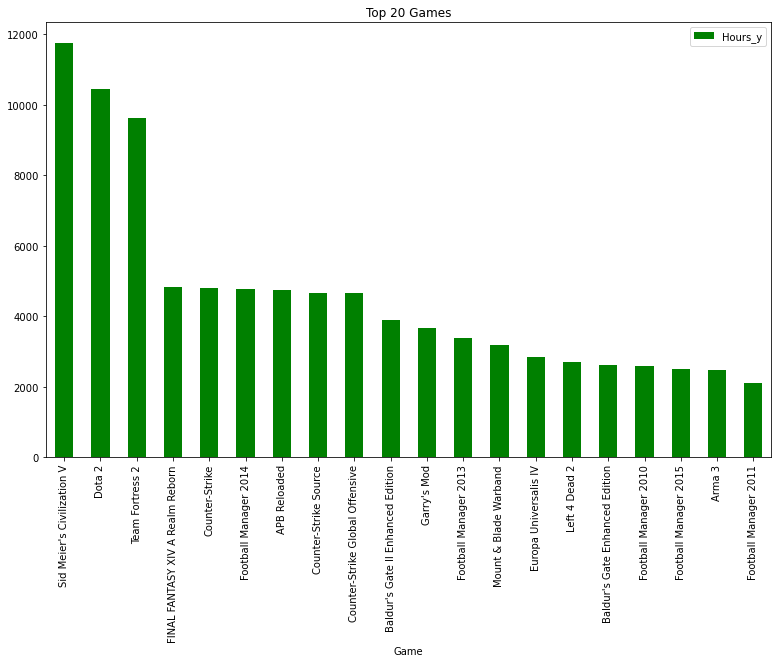

In [28]:
top_hours = steam_clean.groupby('Game')['Hours_y'].max().reset_index()
top_hours = top_hours.sort_values(by=['Hours_y'], ascending = False)
top_games = top_hours.head(20)

top_games_graph = top_games[['Game', 'Hours_y']].plot.bar(x = 'Game', y = 'Hours_y', figsize = (13, 8), title = "Top 20 Games", color = "green")

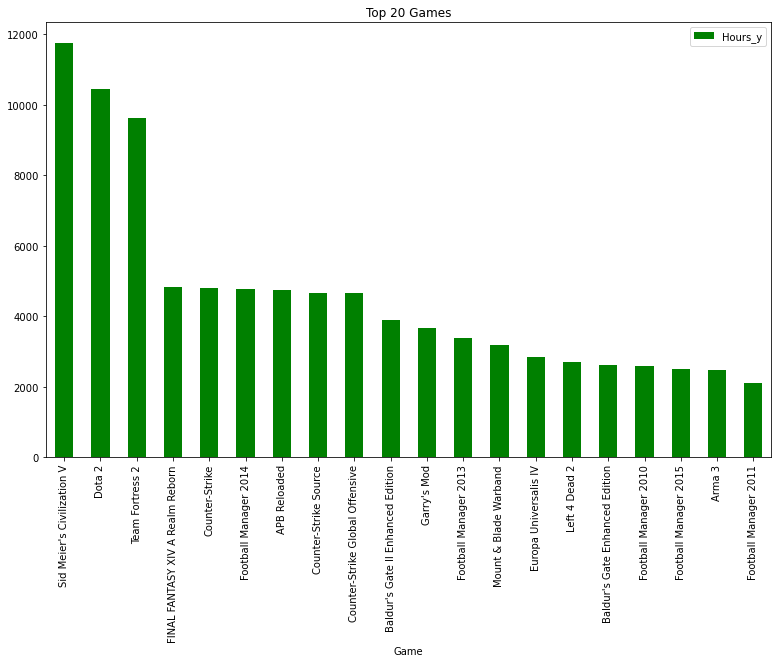

In [29]:
top_hours = steam_clean.groupby('Game')['Hours_y'].max().reset_index()
top_hours = top_hours.sort_values(by=['Hours_y'], ascending = False)
top_games = top_hours.head(20)

top_games_graph = top_games[['Game', 'Hours_y']].plot.bar(x = 'Game', y = 'Hours_y', figsize = (13, 8), title = "Top 20 Games", color = "green")

In [31]:
import math
from scipy import stats
import statistics as st

import operator

In [35]:
#user_hours is a list of all the hours that each user put into the game we are calculating the frequency for
#hours_i is the hours for that specific user for the game
def frequency(hours_i, user_hours):
    if user_hours == 0:
        return 0
    elif hours_i == user_hours:
        return 1
    return hours_i/(user_hours - hours_i)

#frequency_list is the list of all the frequencies between the user k and the top user
#frequency is the calculated frequency for that user
def rating(frequency_sum):
    return 4*(1-frequency_sum)+1

In [36]:
#print(steam_clean2.iloc[steam_length-1])
#print(steam_length)
b = 0
for b in range(0, 2):
    print(b)

0
1


In [37]:
#first we need to create a table with all of the games and the total hours put into each
game_hours = steam_clean.groupby(['Game'])['Hours_y'].sum().reset_index()

#now we can use this information in the frequency function
steam_clean2 = steam_clean
steam_length = int(len(steam_clean2.index))
i = 0
steam_clean2['Frequency'] = np.nan
for i in range(0, steam_length):
    hours_i = steam_clean2.iloc[i][2]
    user_hours = game_hours[game_hours['Game'] == steam_clean2.iloc[i][1]].iloc[0][1] #- steam_clean2.iloc[i][2]
#    print(hours_i)
#    print(user_hours)
#    steam_clean2.iloc[i]['Frequency'] = hours_i/user_hours
    steam_clean2.at[i, 'Frequency'] = frequency(hours_i, user_hours)
#    print(steam_clean2.iloc[i]['Frequency'])
    #steam_clean2.iloc[i]['Frequency'] = frequency(hours_i, user_hours)
    #    steam_clean2.iloc[i]['Frequency'] = frequency(steam_clean2.iloc[i][2], game_hours[game_hours['Game'] == steam_clean2.iloc[i][1]].iloc[0][1] - steam_clean2.iloc[i][2])

In [38]:
#print(steam_clean.iloc[1][1])
#print(game_hours[game_hours['Game'] == 'Alan Wake'].iloc[0][1])
#print(game_hours)
steam_clean3 = steam_clean2

steam_clean3['Rating'] = np.nan
steam_clean3.sort_values(by = ['Game', 'Frequency'], inplace = True, ascending = False, ignore_index = True)

print(steam_clean3)
#for i in range(0, steam_length):
    #need a way to get all of the frequencies greater than the frequency for that user for that game at i

          User_ID                                               Game  Hours_y  \
0       159800136                                   theHunter Primal     71.0   
1        62878249                                   theHunter Primal      9.4   
2       207424334                                   theHunter Primal      4.6   
3       157080495                                   theHunter Primal      0.9   
4        43913966                                          theHunter     95.0   
...           ...                                                ...      ...   
129530   35701646  1... 2... 3... KICK IT! (Drop That Beat Like a...      0.0   
129531   11940338                                          0RBITALIS      0.6   
129532   86055705                                          0RBITALIS      0.3   
129533   93030550                                          0RBITALIS      0.3   
129534   46055854                                        007 Legends      0.7   

        Frequency  Rating  

In [39]:
store = "" #flag to see if we have moved on to a new game
sum_f = 0 #running frequency sum
last_f = 0 #flag to see if there are mutliple users with the same frequency
last_r = 0 #if multiple users with same frequency, want to give same rating

for i in range(0, steam_length): #go through the entire dataframe
    temp = steam_clean3.iloc[i][1] #find out which game we are one
    f_i = steam_clean3.iloc[i][3] #find out the frequency for that game and user    
    
    if temp != store: #if it's the first time we are going over the game
        store = temp #indicate we are now on a new game and save it's name
        if f_i == 0.0: #if there are no hours for the game
            sum_f = 0 #reset running sum
            last_f = 0 #reset last frequency
            last_r = 1 #set last rating
            steam_clean3.at[i, 'Rating'] = 1  #if there are no hours, give it the lowest rating
        else: #if there are hours for the game, must be the top user
            sum_f = f_i #first time on this game so sum is the frequency
            last_f = f_i #set last frequency
            last_r = 5 #set last rating
            steam_clean3.at[i, 'Rating'] = 5 #return the highest rating b/c top user
        
    else: #it's not the first time on this game
        if f_i == 0: #multiple users have zero hours
            last_r = 1 #set last rating 
            steam_clean3.at[i, 'Rating'] = 1 #return lowest score; don't need to reset anything
        elif last_f == f_i: #if there are multiple users with the same frequency
            sum_f += f_i #add to running sum
            steam_clean3.at[i, 'Rating'] = last_r #return last rating
        else:
            rating_f = rating(sum_f)  #calculate the rating
            sum_f += f_i #update the sum
            last_f = f_i #update the last frequency
            last_r = rating_f #update the last rating
            steam_clean3.at[i, 'Rating'] = rating_f

In [40]:
steam_clean4 = steam_clean3
steam_clean4.sort_values(by = ['User_ID', 'Game'], inplace = True, ignore_index = True)
# remove the games with no hours played
steam_clean4 = steam_clean4[steam_clean4['Rating'] != 1]
print(steam_clean4)

          User_ID                          Game  Hours_y     Frequency  \
0            5250                   Alien Swarm      4.9  3.266449e-03   
1            5250               Cities Skylines    144.0  4.710192e-02   
6            5250      Deus Ex Human Revolution     62.0  1.758666e-02   
7            5250                        Dota 2      0.2  2.037315e-07   
17           5250                      Portal 2     13.6  1.493931e-03   
...           ...                           ...      ...           ...   
129528  309434439                        Dota 2      0.8  8.149264e-07   
129529  309554670             Mitos.is The Game      5.9  2.987342e-02   
129530  309626088  Age of Empires II HD Edition      6.7  9.778452e-04   
129533  309824202                        Dota 2      0.7  7.130605e-07   
129534  309903146                        Dota 2      0.2  2.037315e-07   

          Rating  
0       1.765477  
1       4.609080  
6       3.214684  
7       0.992064  
17      1.681515

In [41]:
#distance function; takes array q and p and calculates modified euclidean distance
def distance(q, p):
    total = 0
    for i in range(0, len(q)):
        total += (q[i]-p[i])**2
#    print(total)
    return math.sqrt(total)/len(q)

#find the k nearest neighbors
def neighbors(df, k_neighbors, user):
    distances = []
    #subset of the original table that contains only the rows for specific user
    user_games = df[df['User_ID'] == user]
    #subset of the original table minus the rows for specific user
    df_subset = df[df['User_ID'] != user]
    #temporary list to hold the ratings for the specific user
    user_temp = []
    #temporary list to hold the ratings for the user we are currently indexed on
    temp = []
    #flag to see if we have moved on to a new user id
    temp_id = 0
    #iterate through the entire subset
    for index, row in df_subset.iterrows():
        #if the game at that particual row is a game that the specific user has
        if row['Game'] in set(user_games['Game']):
            #if it is, check to see if we are on a new user or not
            if row['User_ID'] == temp_id:
                #if not, add the rating to the temp list
                temp.append(row['Rating'])
                #also add the rating to the user temp list
                user_temp.append(user_games.loc[user_games['Game'] == row['Game'], 'Rating'].iloc[0])
            #if it's the first time running the loop; set temp_id, add temp_id, game, and ratings
            #but do not calculate distance
            elif temp_id == 0:
                temp_id = row['User_ID']
                temp.append(row['Rating'])
                user_temp.append(user_games.loc[user_games['Game'] == row['Game'], 'Rating'].iloc[0])
            #not the first time running the loop
            #new user
            else:
                #calculate distance for previous user
                dist = distance(user_temp, temp)
                #add that to distances along with the id
                distances.append((temp_id, dist))
                #set the flag to the new id
                temp_id = row['User_ID']
                #reset temp and user_temp
                temp = []
                temp.append(row['Rating'])
                user_temp = []
                user_temp.append(user_games.loc[user_games['Game'] == row['Game'], 'Rating'].iloc[0])
    #once we finish for loop, sort distances so smallest are first
    distances.sort(key=operator.itemgetter(1))
    neighbor_list =[]
    #insert neighbors into the list, smallest distance first up to the kth neighbor
    for i in range(k_neighbors):
        neighbor_list.append(distances[i])
    #return the list of k neighbors
    return neighbor_list
        
#recommend games based on the neighbors' ratings
def recommend(user, neighbor_list, df):
    #which games the user already has
    user_games = df[df['User_ID'] == user]
    dissim_games = []
    #go through all the neighbors
    for neighbor in neighbor_list:
        #make a temporary table containing all of the games that the neighbor has but the user does not
        temp = df[(df['User_ID'] == neighbor[0]) & (~df['Game'].isin(user_games['Game']))]
        #loop through the games in temp
        for index, game in temp.iterrows():
            #add the game and its rating to the dissimilar games list
            dissim_games.append((game['Game'], game['Rating']))
    #sort the dissimilar games list by the game name
    dissim_games.sort(key=operator.itemgetter(0))
    #flag to see if moved on to a new game
    flag = ""
    #running sum of all the ratings
    running_sum = 0
    #list we will add the recomendations to
    rec_list = []
    #count of how many times the game was in dissim_games
    count = 0
    #loop through all of the games
    for dis in dissim_games:
        #if it's the first time the game has come up in the loop
        if flag != dis[0]:
            #if it's not the first time the loop has run
            #if it was then we do not want to append anything
            if flag != "":
                #append the last game name and the average rating
                rec_list.append((flag, running_sum/count))
            #set the flag to the new gae
            flag = dis[0]
            #set the running sum to the current rating
            running_sum = dis[1]
            #reset the counter
            count = 1
        #multiple ratings for the same game
        else:
            #add the current rating to the running sum
            running_sum += dis[1]
            #increment the counter
            count += 1
    #sort the list of recommended games with the highest rating first
    sort_list = sorted(rec_list, key=operator.itemgetter(1), reverse = True)
    return(sort_list)
        
def rec_games(rec_tuple):
    games = []
    for pair in rec_tuple:
        games.append(pair[0])
    return games

In [42]:
test_neighbors = neighbors(steam_clean4, 10, 159800136)
print(test_neighbors)

[(44010163, 0.0), (87601770, 0.0), (115003799, 0.0), (115784259, 0.0), (131949880, 0.0), (137949393, 0.0), (142215921, 0.0), (143275153, 0.0), (143987972, 0.0), (144114673, 0.0)]


In [6]:
recs = recommend(159800136, test_neighbors, steam_clean4)
recommended_games = rec_games(recs)
print(recommended_games)

NameError: name 'recommend' is not defined

In [5]:
def knn(user, k_neighbors, df):
    knearest = neighbors(df, k_neighbors, user)
    rec_list = recommend(user, knearest, df)
    games = rec_games(rec_list)
    return games
print(knn(159800136, 10, df=True))

NameError: name 'neighbors' is not defined